**Brain Tumor Detection**

Dataset: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/data (7,023 images)

In [2]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
!kaggle datasets download -d rm1000/brain-tumor-mri-scans

Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0




  0%|          | 0.00/236M [00:00<?, ?B/s]
  0%|          | 1.00M/236M [00:00<00:43, 5.69MB/s]
  2%|▏         | 5.00M/236M [00:00<00:12, 18.7MB/s]
  3%|▎         | 8.00M/236M [00:00<00:10, 22.3MB/s]
  5%|▌         | 12.0M/236M [00:00<00:11, 20.9MB/s]
  7%|▋         | 16.0M/236M [00:00<00:08, 25.8MB/s]
  8%|▊         | 20.0M/236M [00:00<00:07, 29.1MB/s]
 10%|█         | 24.0M/236M [00:01<00:07, 29.6MB/s]
 12%|█▏        | 28.0M/236M [00:01<00:07, 30.8MB/s]
 14%|█▎        | 32.0M/236M [00:01<00:06, 31.0MB/s]
 15%|█▌        | 36.0M/236M [00:01<00:07, 29.6MB/s]
 17%|█▋        | 40.0M/236M [00:01<00:06, 31.1MB/s]
 19%|█▊        | 44.0M/236M [00:01<00:07, 27.9MB/s]
 20%|██        | 48.0M/236M [00:01<00:06, 29.9MB/s]
 22%|██▏       | 52.0M/236M [00:01<00:06, 32.0MB/s]
 24%|██▎       | 56.0M/236M [00:02<00:06, 30.5MB/s]
 25%|██▍       | 59.0M/236M [00:02<00:06, 29.3MB/s]
 27%|██▋       | 64.0M/236M [00:02<00:05, 33.9MB/s]
 29%|██▉       | 68.0M/236M [00:02<00:05, 34.2MB/s]
 30%|███       | 72.

In [ ]:
!unzip /content/brain-tumor-mri-scans.zip -d /content/brain-tumor-mri-scans/

In [31]:
import os
dataset_path = './brain-tumor-mri-scans/'

# List the folders inside the dataset directory
print(os.listdir(dataset_path))

['glioma', 'healthy', 'meningioma', 'pituitary']


In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from PIL import Image


In [33]:
from PIL import Image

image_dir = "./brain-tumor-mri-scans/"  # Change to the actual path

# Categories
categories = ["glioma", "healthy", "meningioma", "pituitary"]

# Function to check image integrity
def check_image_integrity(image_dir):
    corrupted_files = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Verify if the image is readable
        except (IOError, SyntaxError) as e:
            corrupted_files.append(img_file)
    return corrupted_files

# Iterate through each category and check for corrupted images
for category in categories:
    category_path = os.path.join(image_dir, category)
    corrupted = check_image_integrity(category_path)
    if corrupted:
        print(f"Corrupted images in {category}: {corrupted}")
        # Remove corrupted files
        for corrupted_img in corrupted:
            os.remove(os.path.join(category_path, corrupted_img))
    else:
        print(f"No corrupted images in {category}")


No corrupted images in glioma
No corrupted images in healthy
No corrupted images in meningioma
No corrupted images in pituitary


In [34]:
import numpy as np

# Function to normalize images: After resizing, normalize the pixel values of the images to the range [0, 1].
def normalize_images(image_dir, target_size=(128, 128)):
    images = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path).resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    return np.array(images)

# Normalize images in each category
all_images = []
labels = []

for i, category in enumerate(categories):
    category_path = os.path.join(image_dir, category)
    images = normalize_images(category_path)
    all_images.append(images)
    labels.extend([i] * len(images))  # Assign label based on the category

# Convert lists to numpy arrays for future model training
all_images = np.concatenate(all_images, axis=0)
labels = np.array(labels)

print("Image data and labels prepared.")


Image data and labels prepared.


In [20]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Define paths and categories
image_dir = "./brain-tumor-mri-scans/"
categories = ["glioma", "healthy", "meningioma", "pituitary"]

# Function to normalize images
def normalize_images(image_dir, target_size=(128, 128)):
    images = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path).resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

# Load and normalize images
all_images = []
labels = []
for i, category in enumerate(categories):
    category_path = os.path.join(image_dir, category)
    images = normalize_images(category_path)
    all_images.append(images)
    labels.extend([i] * len(images))  # Assign label based on category

all_images = np.concatenate(all_images, axis=0)
labels = np.array(labels)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=0.2, random_state=42)


In [35]:
from sklearn.decomposition import PCA

# Flatten the image data
all_images_flattened = all_images.reshape(all_images.shape[0], -1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Experiment with different values
all_images_pca = pca.fit_transform(all_images_flattened)

print("PCA transformation completed.")


PCA transformation completed.


In [37]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Model
print(categories)
gmm = GaussianMixture(n_components=len(categories), random_state=42, covariance_type='full')
gmm_labels = gmm.fit_predict(all_images_pca)

print("GMM clustering completed.")


['glioma', 'healthy', 'meningioma', 'pituitary']
GMM clustering completed.


In [ ]:
# Map clusters to categories based on most frequent true label
cluster_to_category = {}
for cluster_id in range(len(categories)):
    cluster_indices = np.where(gmm_labels == cluster_id)[0]
    cluster_labels = labels[cluster_indices]
    if len(cluster_labels) > 0:
        most_common_label = np.bincount(cluster_labels).argmax()
        cluster_to_category[cluster_id] = categories[most_common_label]

# Update GMM labels to category names
gmm_category_labels = [cluster_to_category.get(label, "Unknown") for label in gmm_labels]
print(set(gmm_category_labels))


{'glioma', 'healthy', 'pituitary'}


In [24]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

# F1 Score
f1 = f1_score(labels, gmm_labels, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(labels, gmm_labels)

# AUC-ROC
labels_bin = label_binarize(labels, classes=range(len(categories)))
roc_auc = roc_auc_score(labels_bin, np.expand_dims(gmm_labels, axis=1), multi_class='ovr')

print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUC-ROC Score: {roc_auc}")


F1 Score: 0.4130041273118831
Confusion Matrix:
[[   6   37 1153  425]
 [ 834  975  146   45]
 [ 229   92  780  544]
 [  63  367   74 1253]]
AUC-ROC Score: 0.6285713176352306


In [26]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.mixture import GaussianMixture

class GMMPredictor(BaseEstimator, ClusterMixin):
    def __init__(self, n_components=3, random_state=None, covariance_type='full'):
        self.n_components = n_components
        self.random_state = random_state
        self.covariance_type = covariance_type
        self.gmm = None

    def fit(self, X, y=None):
        self.gmm = GaussianMixture(
            n_components=self.n_components,
            random_state=self.random_state,
            covariance_type=self.covariance_type
        )
        self.gmm.fit(X)
        return self

    def predict(self, X):
        return self.gmm.predict(X)


# Perform cross-validation
gmm_cv = GMMPredictor(n_components=len(categories), random_state=42, covariance_type='full')
cross_val_scores = cross_val_score(gmm_cv, all_images_pca, labels, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {cross_val_scores.mean()}")



Cross-Validation Scores: [0.76227758 0.01209964 0.17437722 0.52991453 0.33119658]
Mean Cross-Validation Accuracy: 0.3619731119019375


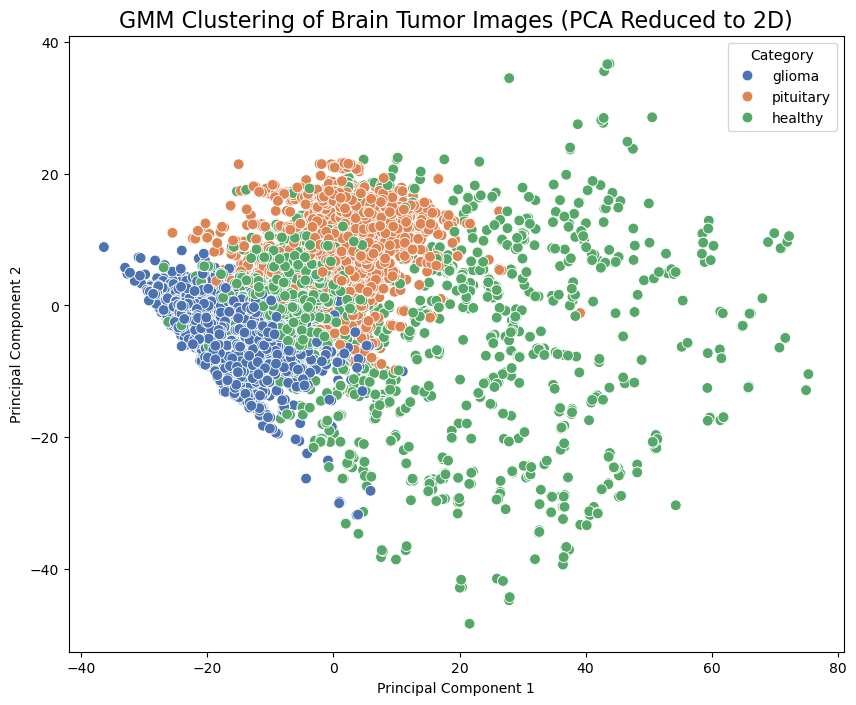

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot using the first two PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=all_images_pca[:, 0], y=all_images_pca[:, 1], hue=gmm_category_labels, palette="deep", s=60)

# Add labels and title
plt.title("GMM Clustering of Brain Tumor Images (PCA Reduced to 2D)", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Category', loc='upper right')

# Show plot
plt.show()


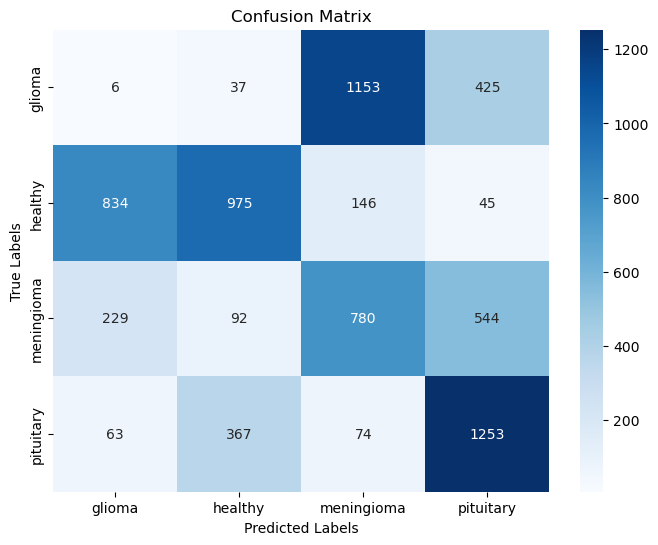

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, gmm_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


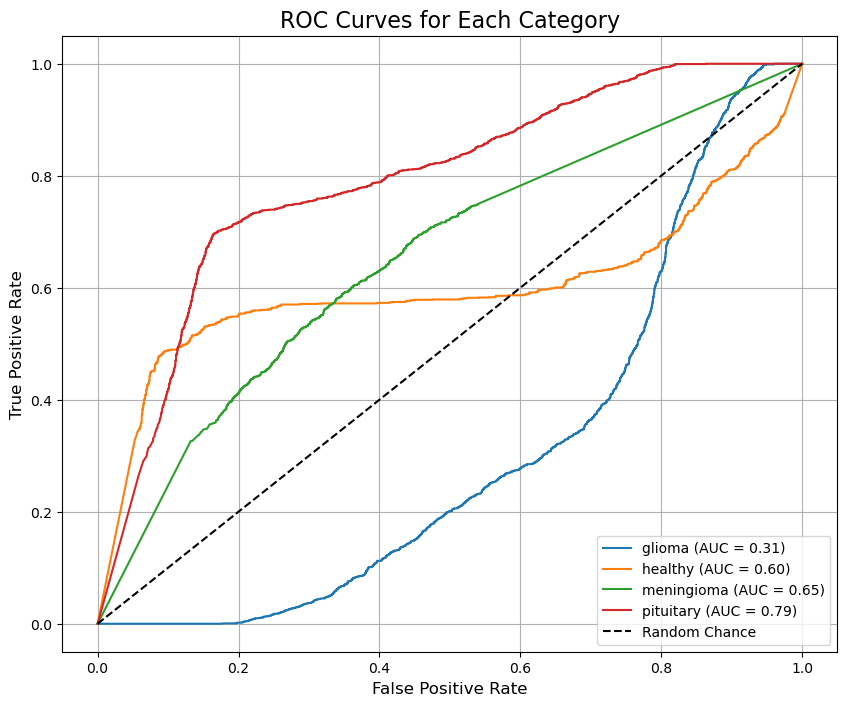

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels for multi-class ROC calculation
labels_bin = label_binarize(labels, classes=range(len(categories)))

# Compute the probability estimates for each cluster
gmm_probs = gmm.predict_proba(all_images_pca)  # GMM provides probabilities for each component

# Initialize a plot
plt.figure(figsize=(10, 8))

# Loop through each category to compute the ROC curve and AUC
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], gmm_probs[:, i])  # True Positive Rate and False Positive Rate
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    plt.plot(fpr, tpr, label=f"{category} (AUC = {roc_auc:.2f})")

# Plot a diagonal line representing random chance
plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="Random Chance")

# Add plot details
plt.title("ROC Curves for Each Category", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()
